For our assignment our first dataset is the placement dataset we found on Kaggle, available at: https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset. Our second dataset is the much larger, and harder Satander Customer Satisfaction dataset. The Satander dataset was actually used as part of a Kaggle competition. For our assignment we'll use the simpler Hotel cancellation dataset to explore the algorithim we are focusing on, and then, we'll use what we learn from our exploration to train a model to perform on the Sarander Customer Satisfaction dataset. 

As per the author "The file contains the different attributes of customers' reservation details." The classification problem is to identify if a succesful algorithim can be trained on predicting if a customer will cancel their reservation.

For our first classification problem, we'll try to develop a model with two classes, those that cancelled their reservation, and those, that did not. 

In [704]:
#No feature scaling required for trees
#Need to do for other 3

In [315]:
import pandas as pd
import numpy as np
import scipy
import sklearn
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import time
import operator

In [731]:
#Function to load and prepare the hotel dataset
def load_hotel():
    df=pd.read_csv('Data/Hotel_Res/Hotel Reservations.csv')
    df=df.drop('arrival_year',axis=1) #Remove Year
    df['season']=df['arrival_month'].apply(lambda x:1 if (x>=4 and x<=9) else 0) #0-Summer, 1-Winter
    df.drop('arrival_month',inplace=True,axis=1)
    df['point_in_month']=df['arrival_date'].apply(lambda x:1 if (x<=15) else 0) #0-eralier in the month,1-later

    #Removing Booking ID as it not a usefull feature
    df=df.drop('Booking_ID',axis=1)

    #Creating the labels (Y)
    Y=np.array(df['booking_status'].apply(lambda x:0 if x=='Not_Canceled' else 1)) #0 if not canceled, 1 if canceled

    df.drop('booking_status',inplace=True,axis=1)

    #Creating the feature vector, X 
    categorical_columns=['type_of_meal_plan', 'room_type_reserved', 'market_segment_type']
    non_categorical_variables=list(set(df.columns).difference(set(categorical_columns+label_columns)))
    X=np.array(df[non_categorical_variables])
    columns_categorized=non_categorical_variables

    #Now we need to one hot vectorize the type_of_meal_plan, room_type_reserved and market_segment_type
    categorical_columns=['type_of_meal_plan','room_type_reserved','market_segment_type']
    label_dict={}
    for i in categorical_columns:
        label_dict[i]=OneHotEncoder()
        res=label_dict[i].fit_transform(np.array(df[i]).reshape(-1,1)).toarray()
        X=np.c_[X,res]
        columns_categorized=columns_categorized+[i+'_'+j for j in ['1','2','3','4','5','6','7'][:res.shape[-1]]]       
    return X,Y

In [727]:
#Load CSR Data

def load_csr_data():
    df_c=pd.read_csv('Data/Satander Customer Satisfaction/data.csv')
    X=np.array(df_c.iloc[:,:-1])
    Y=np.array(df_c.iloc[:,-1])

    return X,Y

In [477]:
#Now let's split the data between test and train, we'll use the standard 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=42)

#We'll also split the data between train and validation, we'll again use the standard 80/20 split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2,random_state=42)

In [485]:
#Creating the train and test split for our much more complicated Satander dataset, we'll again use the standard 80/20 split
X_sd=np.array(df_c.iloc[:,:-1])
Y_sd=np.array(df_c.iloc[:,-1])

#Test & Train
X_train_sd,X_test_sd,y_train_sd,y_test_sd=train_test_split(X_sd, Y_sd, test_size=0.2,random_state=42)

#Validation & Train
X_train_sd, X_valid_sd, y_train_sd, y_valid_sd = train_test_split(X_train_sd, y_train_sd, test_size=0.2,random_state=42)

### Decision Trees

In [462]:
#With out preprocessing completed and our data split, we are ready to use our first algorithim, the Decision Tree. Let's begin by not specifying any optional keyword arguments

decision_tree=DecisionTreeClassifier()
decision_tree.fit(X_train,y_train)

#Let's see the accuracy on the training data & test data
pred=decision_tree.predict(X_train)

print('The accuracy score for the default tree on training data is {}'.format(sklearn.metrics.accuracy_score(y_pred=pred,y_true=y_train)))

pred=decision_tree.predict(X_valid)
print('The accuracy score for the default tree on validation data is {}'.format(sklearn.metrics.accuracy_score(y_pred=pred,y_true=y_valid)))

The accuracy score for the default tree on training data is 0.9945727084769125
The accuracy score for the default tree on validation data is 0.8569951757408684


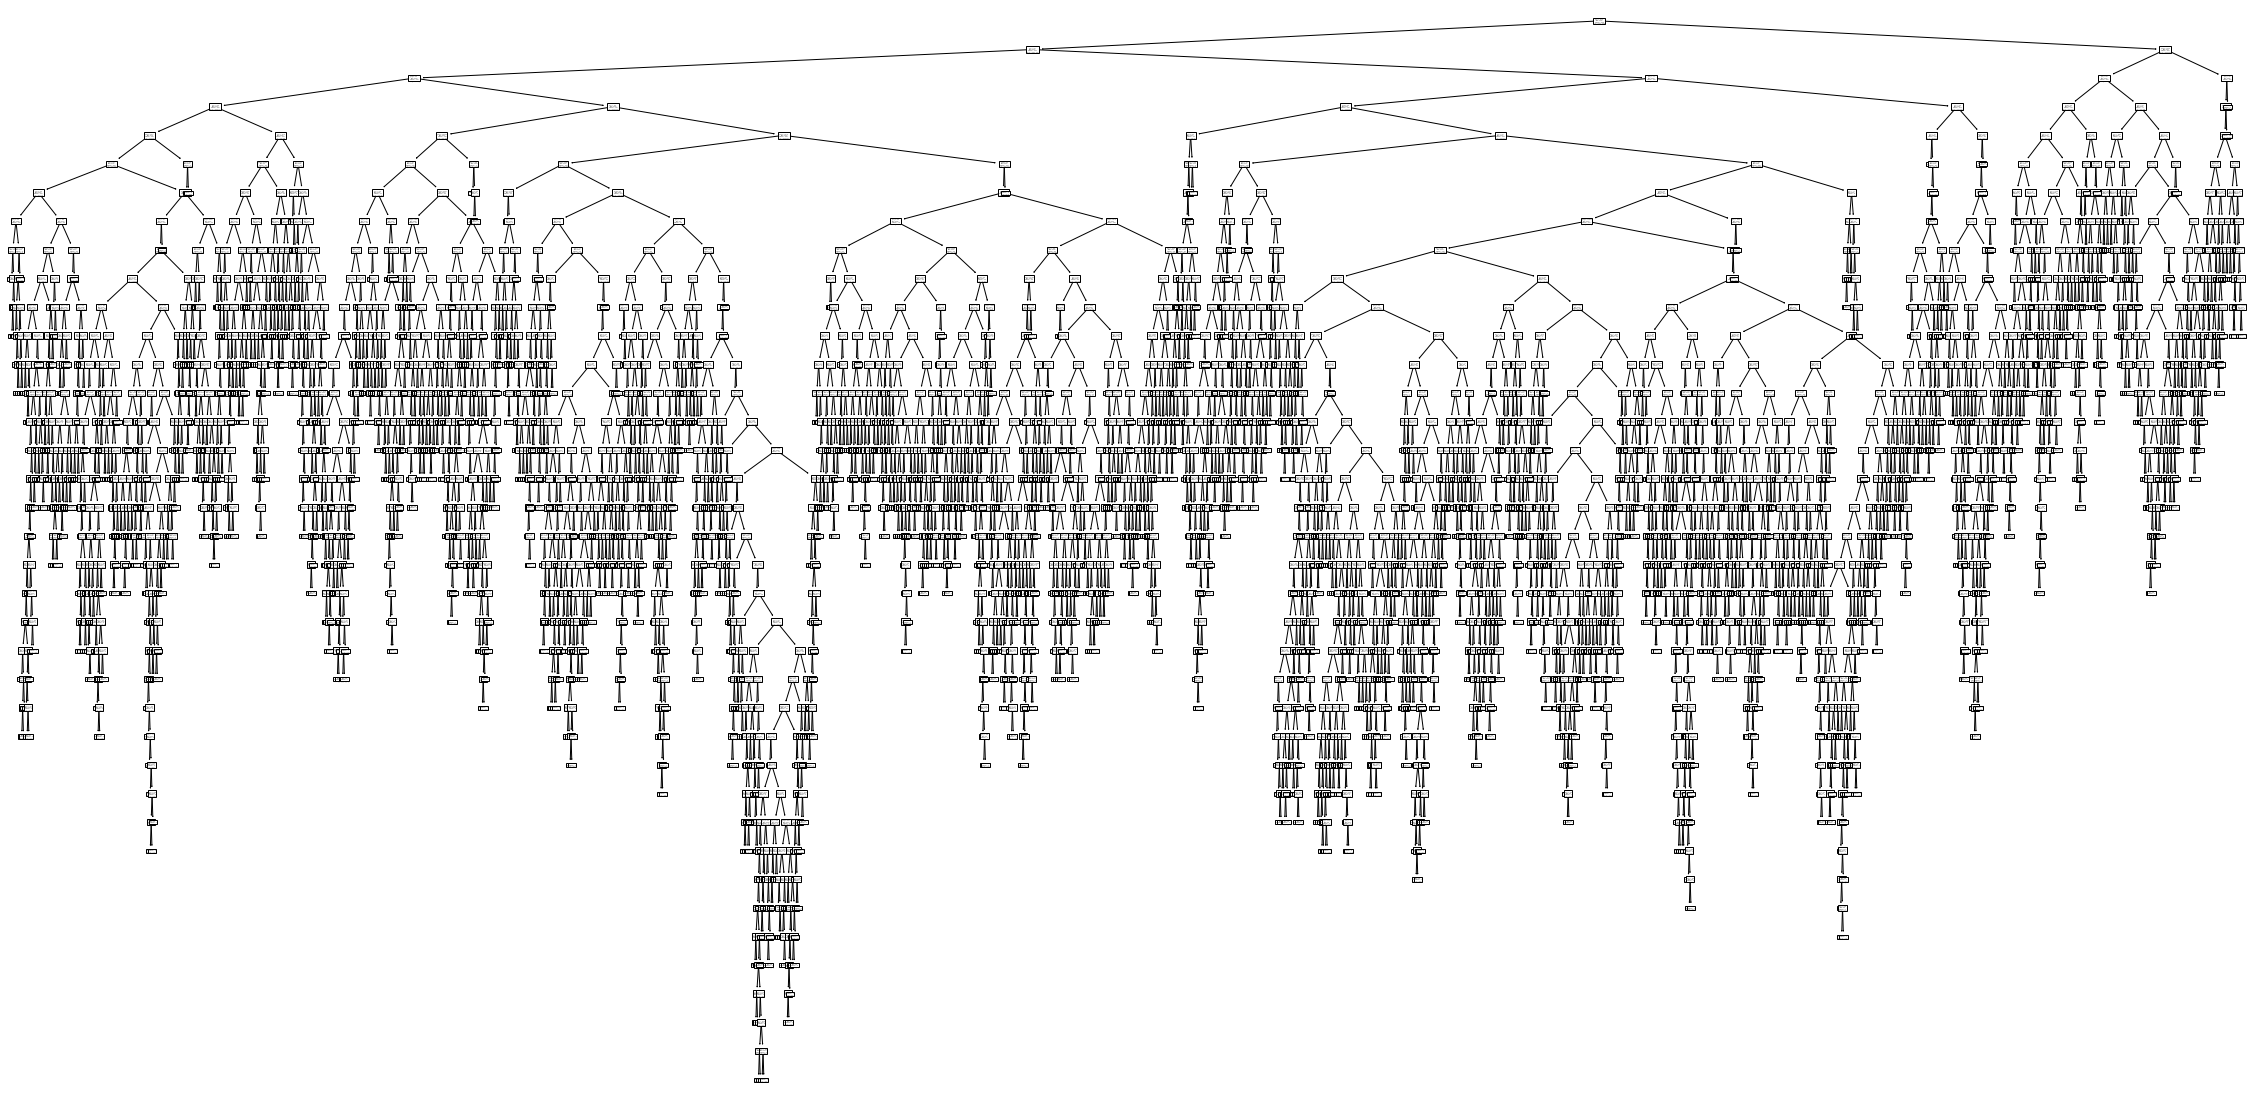

In [463]:
#Let's plot the tree
plt.figure(figsize=(40,20))
sklearn.tree.plot_tree(decision_tree);

It appears that the decision tree has overfit the data. Judging by the accuracy, the degree of overfitting seems significant. In this simple experiment, we've identified a problem with decision trees. Without specifying maximum depth, minimum samples for a split, and without pruning the data, we observe that overfitting is quite possible.

Let's now go do an experiment, let's change the factors mentioned one by one, and see the effect on train & test accuracy, letting us get a feel for overfitting

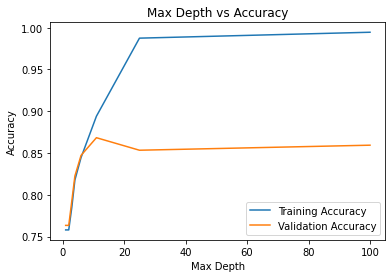

In [464]:
#Let's begin by changing the maximum depth, we'll choose several values and see how the accuracy for the tree changes for both training and test data, we'll be logarathimically decreasing the depth 

max_depth_list=sorted(list(set([int(np.round(100/i**2)) for i in range(1,11)])),reverse=True)
train_acc=[]
test_acc=[]
best_max_depth=None

for i in max_depth_list:
    classifier=DecisionTreeClassifier(max_depth=i)

    classifier.fit(X_train,y_train)
    train_acc.append(sklearn.metrics.accuracy_score(y_pred=classifier.predict(X_train),y_true=y_train))
    test_acc.append(sklearn.metrics.accuracy_score(y_pred=classifier.predict(X_valid),y_true=y_valid))

best_max_depth=max_depth_list[np.argmax(test_acc)]
plt.plot(max_depth_list,train_acc,label='Training Accuracy')
plt.plot(max_depth_list,test_acc,label='Validation Accuracy')
#plt.xscale('log')
plt.legend()
plt.ylabel('Accuracy');
plt.xlabel('Max Depth');
plt.title('Max Depth vs Accuracy');

The graph above is quite interesting, can see how the training accuracy always improves as depth increases. The same is not true for test accuracy. With test accuracy having more of a quadratic curve, increase (model underfit), then reaching a peak, then decrease (model overfit). With max depth explored let's turn our attention to the next metric we'll vary, the minimum samples for a split.

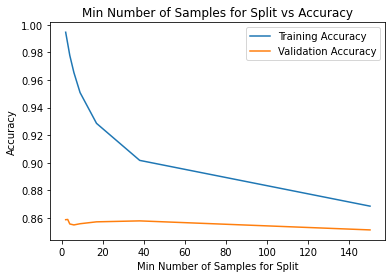

In [465]:
#Let's now change the minimum samples for a split, similar to above, we'll choose several values and see how the accuracy for the tree changes for both training and test data, we'll be logarithmically decreasing the min number of samples

min_num_samples =sorted(list(set([int(np.round(150/i**2)) for i in range(1,11)])),reverse=True)
train_acc=[]
test_acc=[]
best_min_num_split=None

for i in min_num_samples:
    classifier=DecisionTreeClassifier(min_samples_split=i)

    classifier.fit(X_train,y_train)
    train_acc.append(sklearn.metrics.accuracy_score(y_pred=classifier.predict(X_train),y_true=y_train))
    test_acc.append(sklearn.metrics.accuracy_score(y_pred=classifier.predict(X_valid),y_true=y_valid))

best_min_num_split=min_num_samples[np.argmax(test_acc)]

plt.plot(min_num_samples,train_acc,label='Training Accuracy')
plt.plot(min_num_samples,test_acc,label='Validation Accuracy')
#plt.xscale('log')
plt.legend()
plt.ylabel('Accuracy');
plt.xlabel('Min Number of Samples for Split');
plt.title('Min Number of Samples for Split vs Accuracy');

We see a similar result to that of our max_depth experiment. Training accuracy increases as the number of samples required to split increases, the same cannot be said for test accuracy, we see it have  more parabolic arc, clearly indicating under fitting if the number of samples to split on is too large, and, overfitting when the number of samples to split on is low.

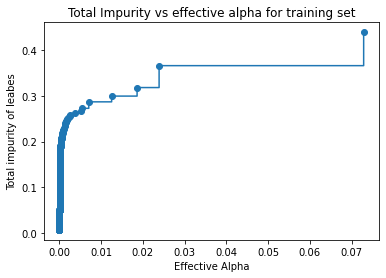

In [466]:
#Now let's add pruning into the mix, we'll be using cost complexity pruning to prune the tree. Simply, cost complexity pruning is an algorithim to prune trees where a split to form leaf nodes can be combined to form one leaf node, with minimal impact to the classifiers predictive ability. Let's try this out.

#Scikit-Learn requires the manipulation of the ccp_alpha parameter to perform pruning, a high ccp_alpha will result in the tree just having one node. Scikit-lean offers a function to find all ccp_alpha values that result in pruning of a leaf node, let's use this for our pruning list

clf=DecisionTreeClassifier()
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

#Plotting the results
plt.plot(ccp_alphas,impurities,marker='o',drawstyle='steps-post')
plt.xlabel('Effective Alpha');
plt.ylabel('Total impurity of leabes');
plt.title('Total Impurity vs effective alpha for training set');
#Reference : https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py

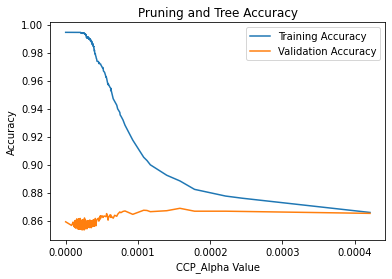

In [559]:
#From our ccp_alphas, let's use all but the last value and see the effect of pruning 
train_acc=[]
test_acc=[]
best_prune_ccp=None
for val in ccp_alphas[:-1]:
    classifier=DecisionTreeClassifier(ccp_alpha=val)

    classifier.fit(X_train,y_train)
    train_acc.append(sklearn.metrics.accuracy_score(y_pred=classifier.predict(X_train),y_true=y_train))
    test_acc.append(sklearn.metrics.accuracy_score(y_pred=classifier.predict(X_valid),y_true=y_valid))

best_prune_ccp=ccp_alphas[np.argmax(test_acc)]
plt.plot(ccp_alphas[:-1],train_acc,label='Training Accuracy')
plt.plot(ccp_alphas[:-1],test_acc,label='Validation Accuracy')
#plt.xscale('log')
plt.legend()
plt.ylabel('Accuracy');
plt.xlabel('CCP_Alpha Value');
plt.title('Pruning and Tree Accuracy');

Here we see an interesting trend the training accuract falls as we prune the tree, but, the test accuracy actually increases initially as the tree is able to generalize to new data better, but, then also begins to fall as now the tree is underfitting the data.

#### Decision Tree Results Hotel

In [468]:
#Now why does it matter? Well a tree that is overfit will not be able to generalize to new data. Let's see an example. What we'll do is, we'll create two trees, one that is default, and one, with our optimized values to increase generalizability.

clf=DecisionTreeClassifier()
clf_optimized=DecisionTreeClassifier(max_depth=best_max_depth,ccp_alpha=best_prune_ccp,min_samples_split=best_min_num_split)

X_tot_train=np.r_[X_train,X_valid]
y_tot_train=np.r_[y_train,y_valid]

clf.fit(X_tot_train,y_tot_train)
clf_optimized.fit(X_tot_train,y_tot_train)

#Unoptimized
print('The accuracy on the training data for the default tree is {}'.format(sklearn.metrics.accuracy_score(y_pred=clf.predict(X_tot_train),y_true=y_tot_train)))
print('The accuracy on the test data for the default tree is {}'.format(sklearn.metrics.accuracy_score(y_pred=clf.predict(X_test),y_true=y_test)))

#Optimized
print('The accuracy on the training data for the optimized tree is {}'.format(sklearn.metrics.accuracy_score(y_pred=clf_optimized.predict(X_tot_train),y_true=y_tot_train)))
print('The accuracy on the test data for the optimized tree is {}'.format(sklearn.metrics.accuracy_score(y_pred=clf_optimized.predict(X_test),y_true=y_test)))

The accuracy on the training data for the default tree is 0.9940041350792557
The accuracy on the test data for the default tree is 0.8610613370089594
The accuracy on the training data for the optimized tree is 0.8765678842177809
The accuracy on the test data for the optimized tree is 0.8662991040661613


As expected, we see a signficant drop in training data accuracy, but, see a signficant improvement in test data accuracy. It appears our second model is generalizing much better than our unoptimized tree. But let's not stop here, let's see the effect of this in a more pronounced fashion. What we'll do is, we'll identify the features that have a strong correlation to the label, and, add noise to them at test time. The correlation will act as a proxy to predictive importance of that feature, and, the noise will further showcase the ability for a model to generalize.

In [469]:
#Let's see the correlation between the features and the label.

col_index={}
results_corr={}
for label,col in zip(columns_categorized,range(X_tot_train.shape[-1])):
    corr=scipy.stats.pearsonr(X[:,col],Y)[0]
    results_corr[label]=corr
    col_index[label]=col
    #print('The pearsonr correlation for the column {} is {}'.format(label,corr))

#Sorting the dictionary by abs personr value and printing
sorted_results_corr={k: v for k, v in sorted(results_corr.items(), key=lambda x: np.abs(x[1]))}

print(sorted_results_corr)

{'room_type_reserved_2': 0.0005477892806356898, 'room_type_reserved_3': -0.0012408787548552683, 'type_of_meal_plan_4': 0.003072260806789967, 'type_of_meal_plan_3': -0.003192910331941173, 'market_segment_type_1': -0.003963564245485795, 'point_in_month': -0.010143401562490714, 'room_type_reserved_5': -0.010223985794527522, 'arrival_date': 0.010629047132925635, 'room_type_reserved_4': 0.013308785702922463, 'room_type_reserved_7': -0.014062191450354936, 'room_type_reserved_1': -0.020325924967843054, 'room_type_reserved_6': 0.03265207205596274, 'no_of_children': 0.03307782091225549, 'no_of_previous_cancellations': -0.03372780323375529, 'market_segment_type_4': -0.038350850373994355, 'no_of_previous_bookings_not_canceled': -0.06017941977524503, 'type_of_meal_plan_1': -0.061267280166042284, 'no_of_weekend_nights': 0.06156253999569561, 'market_segment_type_2': -0.07286712717474665, 'required_car_parking_space': -0.086185276946718, 'type_of_meal_plan_2': 0.08637022420666969, 'no_of_adults': 0.0

We see that lead_time was positively correlated with cancellations, the earlier a reservation is made, the more likely it may be cancelled. Similary, number of special requests is negatively correlated with cancellations, more special requests, less likely the reservation will be cancelled. 

Now here's what we'll do, we'll repeat what we did above with the default and optimized classifier, but add non-trivial noise to the data.

In [776]:
#Getting distributions for our two features with the highest predictive power, from our test set

lead_mean,lead_std=np.mean(X_test[:,col_index['lead_time']]),np.std(X_test[:,col_index['lead_time']])
special_req_mean,special_requests_std=np.mean(X_test[:,col_index['no_of_special_requests']]),np.std(X_test[:,col_index['no_of_special_requests']])

Fitting 3 folds for each of 48 candidates, totalling 144 fits


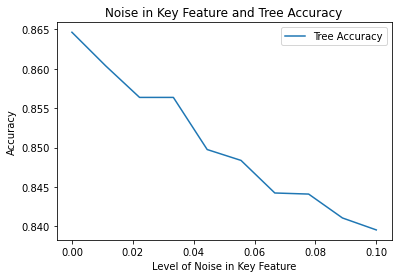

In [783]:
#Seeing the effect of noise on the two classifier's

level_of_noise=[]
clf_accuracy=[]
clf_o_accuracy=[]

#GridSearch
#Grid Search
Params={
'max_depth':[5,10,20],
'min_samples_split':[38, 17, 6, 2],
'ccp_alpha':[0.001,0.01,0.1,0.25]
}

clf=GridSearchCV(DecisionTreeClassifier(),param_grid=Params,verbose=3,n_jobs=-1,cv=3,scoring='accuracy')
clf.fit(X_train,y_train)

for i in np.linspace(0,.1,10):
    #Creating Distributions to add
    lead_dist=np.random.normal(lead_mean*i,lead_std*i,X_test.shape[0])
    special_req_dist=np.random.normal(special_req_mean*i,special_requests_std*i,X_test.shape[0])

    #Now let's add this to our test X data
    X_test_altered=X_test.copy()

    X_test_altered[:,col_index['lead_time']]=X_test_altered[:,col_index['lead_time']]+lead_dist
    X_test_altered[:,col_index['no_of_special_requests']]=X_test_altered[:,col_index['no_of_special_requests']]+special_req_dist

    #Appending Level of noise
    level_of_noise.append(i)

    # #Unoptimized
    # clf_accuracy.append(sklearn.metrics.accuracy_score(y_pred=clf.predict(X_test_altered),y_true=y_test))

    #Optimized
    clf_o_accuracy.append(sklearn.metrics.accuracy_score(y_pred=clf_optimized.predict(X_test_altered),y_true=y_test))

#Plotting
#plt.plot(level_of_noise,clf_accuracy,label='Default Tree Accuracy')
plt.plot(level_of_noise,clf_o_accuracy,label='Tree Accuracy')
#plt.xscale('log')
plt.legend()
plt.ylabel('Accuracy');
plt.xlabel('Level of Noise in Key Feature');
plt.title('Noise in Key Feature and Tree Accuracy');

We've covered the decision tree in some detail in the experiments above, particular focusing on the ability of a decision tree to overfit during training. Now let's focus on another limitation of decision trees, that of heaviliy unbalanced datasets, decision trees perform poorly in these instances. Let's alter our dataset so it's unbalanced and then perfrom some evaluations. We'll use the same optimized parameters as before.

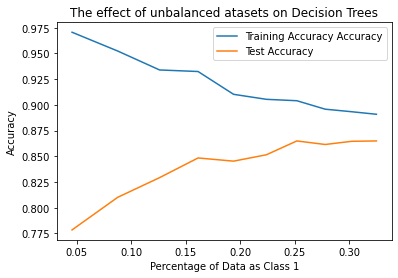

In [472]:
#Converting the balanced dataset into an unbalanced dataset

ind_1=np.argwhere(y_train==1)
ind_0=np.argwhere(y_train==0)
train_acc=[]
test_acc=[]
class_1_size=[]
#Now let's perform the experiment and create a graph at the end

for percentage_of_ones_factor in np.linspace(0.1,1,10):
    #Sampling
    selected_ind=np.random.choice(ind_1.ravel(),size=int(len(ind_1)*percentage_of_ones_factor))
    X_train_unbalanced=np.r_[X_train[ind_0.ravel(),:],X_train[selected_ind,:]]
    y_train_unbalanced=np.r_[y_train[ind_0.ravel()],y_train[selected_ind]]
    class_1_size.append(len(selected_ind)/(len(selected_ind)+len(ind_0)))

    #Let's now trian and test the dataset
    clf_optimized=DecisionTreeClassifier(max_depth=best_max_depth,ccp_alpha=best_prune_ccp,min_samples_split=best_min_num_split)

    clf_optimized.fit(X_train_unbalanced,y_train_unbalanced)
    
    #Testing with validation data not having been 'unbalanced'
    train_acc.append(sklearn.metrics.accuracy_score(y_pred=clf_optimized.predict(X_train_unbalanced),y_true=y_train_unbalanced))

    test_acc.append(sklearn.metrics.accuracy_score(y_pred=clf_optimized.predict(X_valid),y_true=y_valid))

#Plotting
plt.plot(class_1_size,train_acc,label='Training Accuracy Accuracy')
plt.plot(class_1_size,test_acc,label='Test Accuracy')
#plt.xscale('log')
plt.legend()
plt.ylabel('Accuracy');
plt.xlabel('Percentage of Data as Class 1');
plt.title('The effect of unbalanced Datasets on Decision Trees');

Let's go over one more limitation of decision trees. Decision trees can overfit tarining data if the there are many features in the data that have no predictive ability, or ability to indicate the underlying distribution. Let's test this out.

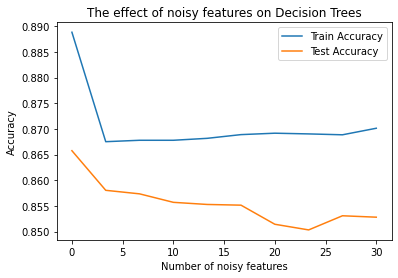

In [473]:
#We'll add features to our training data, that are just noise, and observe the effect on the classifier. This time, we'll let optimize the parameters again, instead of relying with what we calculated earlier, we won't prune the tree though, as finding the ideal pruning value takes some time, and, given the number of rows, coupled with the objective of this exercise, it is not too important. 

clf_o_accuracy_noisy_train=[]
clf_o_accuracy_noisy_test=[]
useless_features=np.linspace(0,30,10)

for uf in useless_features:
    X_noisy=X.copy()
    X_noisy=np.c_[X_noisy,np.random.normal(size=(X.shape[0],int(uf)))]

    #Same as before splitting the data into train,test & validation data
    X_train_noisy, X_test_noisy, y_train_noisy, y_test_noisy = train_test_split(X_noisy, Y, test_size=0.2,random_state=42)

    X_train_noisy, X_valid_noisy, y_train_noisy, y_valid_noisy = train_test_split(X_train_noisy, y_train_noisy, test_size=0.2,random_state=42)

    #Getting the optimized parameters
    max_depth_list=sorted(list(set([int(np.round(100/i**2)) for i in range(1,11)])),reverse=True)
    test_acc=[]
    best_max_depth_noisy=None

    #Depth
    for i in max_depth_list:
        classifier=DecisionTreeClassifier(max_depth=i)

        classifier.fit(X_train_noisy,y_train_noisy)
        test_acc.append(sklearn.metrics.accuracy_score(y_pred=classifier.predict(X_valid_noisy),y_true=y_valid_noisy))

    best_max_depth_noisy=max_depth_list[np.argmax(test_acc)]

    min_num_samples =sorted(list(set([int(np.round(150/i**2)) for i in range(1,11)])),reverse=True)
    test_acc=[]
    best_min_num_split_noisy=None

    #Min number of samples
    for i in min_num_samples:
        classifier=DecisionTreeClassifier(min_samples_split=i)

        classifier.fit(X_train_noisy,y_train_noisy)
        test_acc.append(sklearn.metrics.accuracy_score(y_pred=classifier.predict(X_valid_noisy),y_true=y_valid_noisy))

    best_min_num_split_noisy=min_num_samples[np.argmax(test_acc)]

    #Pruning value
    # clf=DecisionTreeClassifier()
    # path = clf.cost_complexity_pruning_path(X_train_noisy, y_train_noisy)
    # ccp_alphas, impurities = path.ccp_alphas, path.impurities
    # train_acc=[]
    # best_prune_ccp_noisy=None
    # for val in ccp_alphas[:-1]:
    #     classifier=DecisionTreeClassifier(ccp_alpha=val)

    #     classifier.fit(X_train_noisy,y_train_noisy)
    #     test_acc.append(sklearn.metrics.accuracy_score(y_pred=classifier.predict(X_valid_noisy),y_true=y_valid_noisy))

    # best_prune_ccp_noisy=ccp_alphas[np.argmax(test_acc)]

    # #Creating optimized tree
    clf_optimized_noisy=DecisionTreeClassifier(max_depth=best_max_depth_noisy,min_samples_split=best_min_num_split_noisy)

    X_tot_train_noisy=np.r_[X_train_noisy,X_valid_noisy]
    y_tot_train_noisy=np.r_[y_train_noisy,y_valid_noisy]
    clf_optimized_noisy.fit(X_tot_train_noisy,y_tot_train_noisy)

    #Optimized
    clf_o_accuracy_noisy_train.append(sklearn.metrics.accuracy_score(y_pred=clf_optimized_noisy.predict(X_tot_train_noisy),y_true=y_tot_train_noisy))

    clf_o_accuracy_noisy_test.append(sklearn.metrics.accuracy_score(y_pred=clf_optimized_noisy.predict(X_test_noisy),y_true=y_test_noisy))

#Plotting
plt.plot(useless_features,clf_o_accuracy_noisy_train,label='Train Accuracy')
plt.plot(useless_features,clf_o_accuracy_noisy_test,label='Test Accuracy')
#plt.xscale('log')
plt.legend()
plt.ylabel('Accuracy');
plt.xlabel('Number of noisy features');
plt.title('The effect of noisy features on Decision Trees');

In the graph we see the impact of adding noisy features. Both the training and test accuracy are impacted by the addition of these features, but, while we see the impact to training accuracy taper off, the same cannot be said for the test accuracy, that continues to decrease. This is because the degree of overfitting increases with noise. 

Now let's use what we have learnt so far to create an optimized decision tree classifier to see if we can accurately predict customer satisfaction in the Satander dataset. Procedure is the same as before.

#### Decision Tree Results Satander

In [487]:
#Satander Sentiment Dataset

#Getting the optimized parameters
max_depth_list=sorted(list(set([int(np.round(100/i**2)) for i in range(1,11)])),reverse=True)
test_acc=[]

#Depth
for i in max_depth_list:
    classifier=DecisionTreeClassifier(max_depth=i)

    classifier.fit(X_train_sd,y_train_sd)
    test_acc.append(sklearn.metrics.accuracy_score(y_pred=classifier.predict(X_valid_sd),y_true=y_valid_sd))

best_max_depth_sd=max_depth_list[np.argmax(test_acc)]

min_num_samples =sorted(list(set([int(np.round(150/i**2)) for i in range(1,11)])),reverse=True)
test_acc=[]

#Min number of samples
for i in min_num_samples:
    classifier=DecisionTreeClassifier(min_samples_split=i)

    classifier.fit(X_train_sd,y_train_sd)
    test_acc.append(sklearn.metrics.accuracy_score(y_pred=classifier.predict(X_valid_sd),y_true=y_valid_sd))

best_min_num_split_sd=min_num_samples[np.argmax(test_acc)]

#Pruning value

clf=DecisionTreeClassifier()
path = clf.cost_complexity_pruning_path(X_train_sd, y_train_sd)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
train_acc=[]
for val in ccp_alphas[:-1]:
    classifier=DecisionTreeClassifier(ccp_alpha=val)

    classifier.fit(X_train_noisy,y_train_noisy)
    test_acc.append(sklearn.metrics.accuracy_score(y_pred=classifier.predict(X_valid_noisy),y_true=y_valid_noisy))

best_prune_ccp_sd=ccp_alphas[np.argmax(test_acc)]

# #Creating optimized tree
clf_optimized_sd=DecisionTreeClassifier(max_depth=best_max_depth_sd,min_samples_split=best_min_num_split_sd,ccp_alpha=best_prune_ccp_sd)

X_tot_train_sd=np.r_[X_train_sd,X_valid_sd]
y_tot_train_sd=np.r_[y_train_sd,y_valid_sd]
clf_optimized_sd.fit(X_tot_train_sd,y_tot_train_sd)

#Default tree to test agains
clf=DecisionTreeClassifier()
clf.fit(X_tot_train_sd,y_tot_train_sd)

#Unoptimized
print('The accuracy on the training data for the default tree is {}'.format(sklearn.metrics.accuracy_score(y_pred=clf.predict(X_tot_train_sd),y_true=y_tot_train_sd)))
print('The accuracy on the test data for the default tree is {}'.format(sklearn.metrics.accuracy_score(y_pred=clf.predict(X_test_sd),y_true=y_test_sd)))

#Optimized
print('The accuracy on the training data for the optimized tree is {}'.format(sklearn.metrics.accuracy_score(y_pred=clf_optimized_sd.predict(X_tot_train_sd),y_true=y_tot_train_sd)))
print('The accuracy on the test data for the optimized tree is {}'.format(sklearn.metrics.accuracy_score(y_pred=clf_optimized_sd.predict(X_test_sd),y_true=y_test_sd)))

The accuracy on the training data for the default tree is 1.0
The accuracy on the test data for the default tree is 0.9265324914496185
The accuracy on the training data for the optimized tree is 0.9605202578268877
The accuracy on the test data for the optimized tree is 0.9600762957116549


In [493]:
#The above result looks very good, until we remember the dataset is extremely unbalanced, let's see what the score would be for a dummy classifier that just guesses 0.
dummy_results=np.zeros(shape=(X_test_sd.shape[0]))
print('Dummy Classifier accuracy score for the test data is {}'.format(sklearn.metrics.accuracy_score(y_pred=dummy_results,y_true=y_test_sd)))

Dummy Classifier accuracy score for the test data is 0.9600762957116549


In [500]:
#We note that the Satander dataset is highly imbalanced, and, as can be seen by the dummy classifier, accuracy is a poor metric for this data. Let's use two other metrics, the AUC and the F1 score. Let's start by the AUC score. We'll repeat the same process as above for the AUC for all three models (default, optimized, dummy) 

#Unoptimized
print('The AUC score on the training data for the default tree is {}'.format(sklearn.metrics.roc_auc_score(y_score=clf.predict(X_tot_train_sd),y_true=y_tot_train_sd)))
print('The AUC score on the test data for the default tree is {}'.format(sklearn.metrics.roc_auc_score(y_score=clf.predict(X_test_sd),y_true=y_test_sd)))

#Optimized
print('The AUC score on the training data for the optimized tree is {}'.format(sklearn.metrics.roc_auc_score(y_score=clf_optimized_sd.predict(X_tot_train_sd),y_true=y_tot_train_sd)))
print('The AUC score on the test data for the optimized tree is {}'.format(sklearn.metrics.roc_auc_score(y_score=clf_optimized_sd.predict(X_test_sd),y_true=y_test_sd)))

#Dummy
print('The AUC score onn the training data for the dummy tree is {}'.format(sklearn.metrics.roc_auc_score(y_score=np.zeros(shape=(X_tot_train_sd.shape[0])),y_true=y_tot_train_sd)))
print('The AUC score on the test data for the dummy tree is {}'.format(sklearn.metrics.roc_auc_score(y_score=np.zeros(shape=(X_test_sd.shape[0])),y_true=y_test_sd)))

The AUC score on the training data for the default tree is 1.0
The AUC score on the test data for the default tree is 0.5480566350491328
The AUC score on the training data for the optimized tree is 0.5
The AUC score on the test data for the optimized tree is 0.5
The AUC score onn the training data for the dummy tree is 0.5
The AUC score on the test data for the dummy tree is 0.5


In [501]:
#Moving onto the F1 Score

#Unoptimized
print('The F1 score on the training data for the default tree is {}'.format(sklearn.metrics.f1_score(y_pred=clf.predict(X_tot_train_sd),y_true=y_tot_train_sd)))
print('The F1 score on the test data for the default tree is {}'.format(sklearn.metrics.f1_score(y_pred=clf.predict(X_test_sd),y_true=y_test_sd)))

#Optimized
print('The F1 score on the training data for the optimized tree is {}'.format(sklearn.metrics.f1_score(y_pred=clf_optimized_sd.predict(X_tot_train_sd),y_true=y_tot_train_sd)))
print('The F1 score on the test data for the optimized tree is {}'.format(sklearn.metrics.f1_score(y_pred=clf_optimized_sd.predict(X_test_sd),y_true=y_test_sd)))

#Dummy
print('The F1 score onn the training data for the dummy tree is {}'.format(sklearn.metrics.f1_score(y_pred=np.zeros(shape=(X_tot_train_sd.shape[0])),y_true=y_tot_train_sd)))
print('The F1 score on the test data for the dummy tree is {}'.format(sklearn.metrics.f1_score(y_pred=np.zeros(shape=(X_test_sd.shape[0])),y_true=y_test_sd)))

The F1 score on the training data for the default tree is 1.0
The F1 score on the test data for the default tree is 0.12938425565081837
The F1 score on the training data for the optimized tree is 0.0
The F1 score on the test data for the optimized tree is 0.0
The F1 score onn the training data for the dummy tree is 0.0
The F1 score on the test data for the dummy tree is 0.0


It appears that none of our trees performed well. The defauly tree overfit the data, and the optimzied tree was unable to identify the underlying pattern. 

### Boosted Decision Trees

The next algorithim, Boosted Decision Trees, is an ensemble method. A decision tree is taken, it's output, namely it's errors is used to augment the training of the next tree. Given our classification problem being binary for both problems, we'll use Log Loss as the loss funciton for our Gradient Boosted algorithim. Let's begin by exploring the parameters for gradient boosted decision trees for our hotel dataset. Given the fundamentals of a gradient boosting classifier, it is no suprise that many of its parameters are shared with that of a decision tree, instead of focusing on these parameters again, we will focus on the new parameters, and automate the optimal value for the other params.

We will be focusing on the learning rate, n_estimators, subsample, !criterion!, !validation fraction! and ccp_alpha (we explored this before, but, with gradient trees we can be more aggressive with pruning so they generalize better).


In [517]:
#Importing Gradint Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

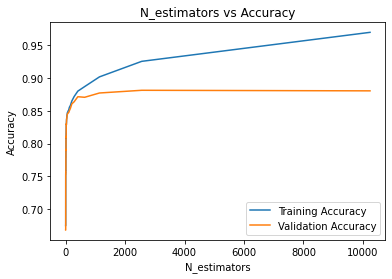

In [523]:
#Let's begin with n_estimators. N_estimators and max_depth from the previous section share some principles in common, too few estiamtors we underfit, too many, we overfit. Let's explor this

#Getting the estimator size list 
n_estimators_log=sorted(list(set([int(np.ceil(10240/i**2)) for i in range(1,320)])))[::-1]
train_acc=[]
test_acc=[]

#Running experiment 
for i in n_estimators_log:
    glf=GradientBoostingClassifier(n_estimators=i)

    glf.fit(X_train,y_train)
    train_acc.append(sklearn.metrics.accuracy_score(y_pred=glf.predict(X_train),y_true=y_train))
    test_acc.append(sklearn.metrics.accuracy_score(y_pred=glf.predict(X_valid),y_true=y_valid))

best_num_estimator_gb=min_num_samples[np.argmax(test_acc)]

plt.plot(n_estimators_log,train_acc,label='Training Accuracy')
plt.plot(n_estimators_log,test_acc,label='Validation Accuracy')
#plt.xscale('log')
plt.legend()
plt.ylabel('Accuracy');
plt.xlabel('N_estimators');
plt.title('N_estimators vs Accuracy');

In [524]:
#We see here that there is a rapid increase in validation accuracy as we increase the number of estimators, initially, but this levels off. The first portion when the accuracy is increasing is when the model is going from an underfit to a good fit region. After this point we clearly see overfitting, as the training accuracy continues to increase, but, the validation accuracy has levelled off.

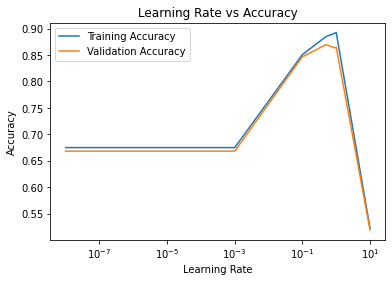

In [542]:
#Now let's move on to the learning rate. If the learning rate is too low, we note that the classifier might not converge, or, may require a less than optimal number of estimators to converge. Too high a leraning rate can make the system unstable, so we may never have convergence, or, we may overshoot the ideal solution. Let's try this out. 

#Learning rate list 
learning_rate_list=[10,1,0.9,0.5,0.1,0.001,0.0001,0.00001,0.000001,0.0000001,0.00000001]

train_acc=[]
test_acc=[]

#Running experiment 
for i in learning_rate_list:
    glf=GradientBoostingClassifier(learning_rate=i)

    glf.fit(X_train,y_train)
    train_acc.append(sklearn.metrics.accuracy_score(y_pred=glf.predict(X_train),y_true=y_train))
    test_acc.append(sklearn.metrics.accuracy_score(y_pred=glf.predict(X_valid),y_true=y_valid))

best_lr_gb=learning_rate_list[np.argmax(test_acc)]

plt.plot(learning_rate_list,train_acc,label='Training Accuracy')
plt.plot(learning_rate_list,test_acc,label='Validation Accuracy')
plt.xscale('log')
plt.legend()
plt.ylabel('Accuracy');
plt.xlabel('Learning Rate');
plt.title('Learning Rate vs Accuracy');


In [547]:
#We see what we expected, learning rate too low, no covnergence, toon high, model falls apart.

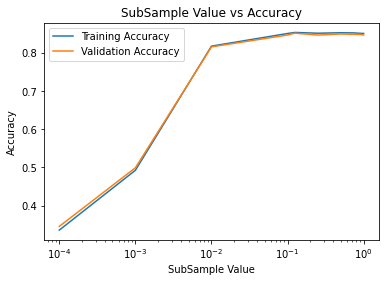

In [566]:
#Now we can move on to the subsample, subsample indicates how much of the sample will be used to grow a tree, too little underfit, too much overfitting
#Learning rate list 
subsample_vals=[1,0.9,0.75,0.5,0.25,0.125,0.1,0.01,0.001,0.0001]

train_acc=[]
test_acc=[]

#Running experiment 
for i in subsample_vals:
    glf=GradientBoostingClassifier(subsample=i)

    glf.fit(X_train,y_train)
    train_acc.append(sklearn.metrics.accuracy_score(y_pred=glf.predict(X_train),y_true=y_train))
    test_acc.append(sklearn.metrics.accuracy_score(y_pred=glf.predict(X_valid),y_true=y_valid))

best_sb_gb=subsample_vals[np.argmax(test_acc)]

plt.plot(subsample_vals,train_acc,label='Training Accuracy')
plt.plot(subsample_vals,test_acc,label='Validation Accuracy')
plt.xscale('log')
plt.legend()
plt.ylabel('Accuracy');
plt.xlabel('SubSample Value');
plt.title('SubSample Value vs Accuracy');

In [567]:
#It appears for this dataset, the subsampling can be increased to 1 without much impact, meaning the tree still able to generalize, but, we note that the highest value is still not 1, we see region of underfit
best_sb_gb

0.125

In [568]:
#friedman_mse find more info why best

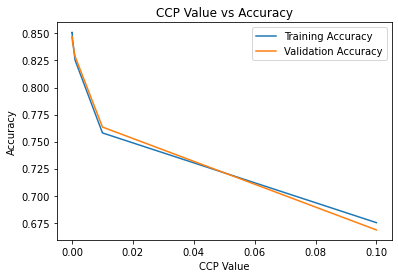

In [584]:
#Now let's go over pruning for gradient boosted deicision trees
ccp_alpha_list=[best_prune_ccp/16,best_prune_ccp/8,best_prune_ccp/4,best_prune_ccp/2,best_prune_ccp,0.001,0.01,0.1] 

train_acc=[]
test_acc=[]

#Running experiment 
for i in ccp_alpha_list:
    glf=GradientBoostingClassifier(ccp_alpha=i)

    glf.fit(X_train,y_train)
    train_acc.append(sklearn.metrics.accuracy_score(y_pred=glf.predict(X_train),y_true=y_train))
    test_acc.append(sklearn.metrics.accuracy_score(y_pred=glf.predict(X_valid),y_true=y_valid))

best_ccp_gd=ccp_alpha_list[np.argmax(test_acc)]

plt.plot(ccp_alpha_list,train_acc,label='Training Accuracy')
plt.plot(ccp_alpha_list,test_acc,label='Validation Accuracy')
#plt.xscale('log')
plt.legend()
plt.ylabel('Accuracy');
plt.xlabel('CCP Value');
plt.title('CCP Value vs Accuracy');

In [585]:
#We see the same as we expected, too little pruning, overfitting, too much underfit the data, as patterns not detectable 

With our parameters now explored, let's take a look at the ideal accuracy for the gradient boosted decision tree on our hotel dataset.

In [603]:
#Getting the ideal parameters with the help of grid search and cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix 

Params={
    'learning_rate':[0.001,0.01,0.1],
    'n_estimators':[50,100,150],
    'subsample':[0.75,0.85,0.95],
    #'max_depth':[2,5,10],
    'ccp_alpha':[0,0.01,0.25],
    'min_samples_split': [35,15,2]
}

grid=GridSearchCV(GradientBoostingClassifier(),param_grid=Params,verbose=3,n_jobs=-1,cv=3,scoring='accuracy')
grid.fit(X_tot_train,y_tot_train)

              precision    recall  f1-score   support

           0       0.87      0.93      0.90     19551
           1       0.84      0.71      0.77      9469

    accuracy                           0.86     29020
   macro avg       0.85      0.82      0.83     29020
weighted avg       0.86      0.86      0.86     29020



In [605]:
#Let's see the best params
grid.best_params_

{'ccp_alpha': 0,
 'learning_rate': 0.1,
 'min_samples_split': 2,
 'n_estimators': 150,
 'subsample': 0.85}

#### Gradient boosted Hotel

In [606]:
#Interestingly there is no pruning recommended, it could be because our max depth is very low. Let's see what the test accuracy is 

gcf=GradientBoostingClassifier()
gcf.fit(X_tot_train,y_tot_train)

#Unoptimized
print('The accuracy on the training data for the default gradient boosted tree is {}'.format(sklearn.metrics.accuracy_score(y_pred=gcf.predict(X_tot_train),y_true=y_tot_train)))
print('The accuracy on the test data for the default gradient boosted tree is {}'.format(sklearn.metrics.accuracy_score(y_pred=gcf.predict(X_test),y_true=y_test)))

#Optimized
print('The accuracy on the training data for the optimized default gradient boosted is {}'.format(sklearn.metrics.accuracy_score(y_pred=grid.predict(X_tot_train),y_true=y_tot_train)))
print('The accuracy on the test data for the optimized default gradient boosted is {}'.format(sklearn.metrics.accuracy_score(y_pred=grid.predict(X_test),y_true=y_test)))

The accuracy on the training data for the default gradient boosted tree is 0.8526878015161957
The accuracy on the test data for the default gradient boosted tree is 0.8460372157133011
The accuracy on the training data for the optimized default gradient boosted is 0.860303239145417
The accuracy on the test data for the optimized default gradient boosted is 0.850723638869745


We see that our accuracy for the gradient boosted tree is actually less than that of our decision tree. Given our data, not too many noisy features, good predictive ability for some features it makes sense decision trees would be a good model. Gradient Boosted Trees really shine where there are many features, and, some are noisy. Let's now try to fit this model to our second, harder dataset, and see the effects, but, before we do that, let's see how it responds to noisy features

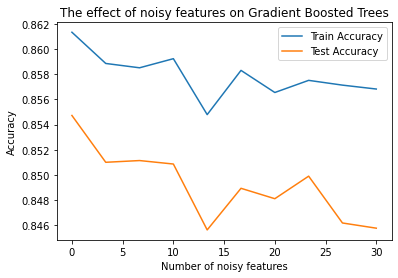

In [609]:
#We'll add features to our training data, that are just noise, and observe the effect on the classifier. This time, we'll let optimize the parameters again, instead of relying with what we calculated earlier. To keep the testing equal, we again won't prune the tree

glf_o_accuracy_noisy_train=[]
glf_o_accuracy_noisy_test=[]
useless_features=np.linspace(0,30,10)

for uf in useless_features:
    X_noisy=X.copy()
    X_noisy=np.c_[X_noisy,np.random.normal(size=(X.shape[0],int(uf)))]

    #Same as before splitting the data into train,test & validation data
    X_train_noisy, X_test_noisy, y_train_noisy, y_test_noisy = train_test_split(X_noisy, Y, test_size=0.2,random_state=42)

    #Getting the optimized parameters
    Params={
        'learning_rate':[0.001,0.01,0.1],
        'n_estimators':[50,100,150],
        'subsample':[0.75,0.85,0.95],
        #'max_depth':[2,5,10],
        'ccp_alpha':[0,0.01,0.25],
        'min_samples_split': [35,15,2]
    }

    grid_n=GridSearchCV(GradientBoostingClassifier(),param_grid=Params,verbose=0,n_jobs=-1,cv=3,scoring='accuracy')
    grid_n.fit(X_train_noisy,y_train_noisy)

    #Optimized
    glf_o_accuracy_noisy_train.append(sklearn.metrics.accuracy_score(y_pred=grid_n.predict(X_train_noisy),y_true=y_train_noisy))

    glf_o_accuracy_noisy_test.append(sklearn.metrics.accuracy_score(y_pred=grid_n.predict(X_test_noisy),y_true=y_test_noisy))

#Plotting
plt.plot(useless_features,glf_o_accuracy_noisy_train,label='Train Accuracy')
plt.plot(useless_features,glf_o_accuracy_noisy_test,label='Test Accuracy')
#plt.xscale('log')
plt.legend()
plt.ylabel('Accuracy');
plt.xlabel('Number of noisy features');
plt.title('The effect of noisy features on Gradient Boosted Trees');

In [628]:
print('The lowest accuracy for the Gradient Boosted Tree was {:.3f} and the highest accuracy was {:.3f} which equates to a loss of {:.3f}'.format(min(glf_o_accuracy_noisy_test),max(glf_o_accuracy_noisy_test),max(glf_o_accuracy_noisy_test)-min(glf_o_accuracy_noisy_test)))

print('The lowest accuracy for the Decision Tree was {:.3f} and the highest accuracy was {:.3f} which equates to a loss of {:.3f}'.format(min(clf_o_accuracy_noisy_test),max(clf_o_accuracy_noisy_test),max(clf_o_accuracy_noisy_test)-min(clf_o_accuracy_noisy_test)))

The lowest accuracy for the Gradient Boosted Tree was 0.846 and the highest accuracy was 0.855 which equates to a loss of 0.009
The lowest accuracy for the Decision Tree was 0.850 and the highest accuracy was 0.866 which equates to a loss of 0.015


We do see a bigger drop in Decision Tree performance as compared to Gradient Boosted Tree performance, again, Gradient Boosted Trees are more robust to noisy features

Noisy Data

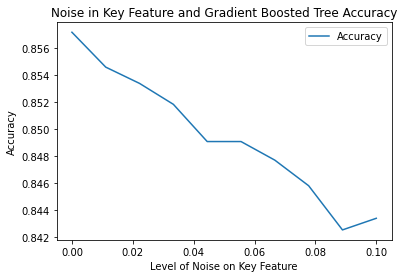

In [775]:
#We know that the most important factor is the lead time, same as before, let's train a dataset and add some noisy data to the lead time for validation and see the effect 
#Getting distributions for our two features with the highest predictive power, from our test set

lead_mean,lead_std=np.mean(X_valid[:,col_index['lead_time']]),np.std(X_valid[:,col_index['lead_time']])
special_req_mean,special_requests_std=np.mean(X_valid[:,col_index['no_of_special_requests']]),np.std(X_valid[:,col_index['no_of_special_requests']])

level_of_noise=[]
glf_accuracy=[]

#Grid Search
Params={
    'learning_rate':[0.001,0.01,0.1],
    'n_estimators':[50,100,150],
    'subsample':[0.75,0.85,0.95],
    #'max_depth':[2,5,10],
    'ccp_alpha':[0,0.01,0.25],
    'min_samples_split': [35,15,2]
}

grid_n=GridSearchCV(GradientBoostingClassifier(),param_grid=Params,verbose=0,n_jobs=-1,cv=3,scoring='accuracy')
grid_n.fit(X_train,y_train)

for i in np.linspace(0,.1,10):
    #Creating Distributions to add
    lead_dist=np.random.normal(lead_mean*i,lead_std*i,X_valid.shape[0])
    special_req_dist=np.random.normal(special_req_mean*i,special_requests_std*i,X_valid.shape[0])

    #Now let's add this to our test X data
    X_valid_altered=X_valid.copy()

    X_valid_altered[:,col_index['lead_time']]=X_valid_altered[:,col_index['lead_time']]+lead_dist
    X_valid_altered[:,col_index['no_of_special_requests']]=X_valid_altered[:,col_index['no_of_special_requests']]+special_req_dist

    #Appending Level of noise
    level_of_noise.append(i)

    #Getting Accuracy
    glf_accuracy.append(sklearn.metrics.accuracy_score(y_pred=grid_n.predict(X_valid_altered),y_true=y_valid))

#Plotting
plt.plot(level_of_noise,glf_accuracy,label='Accuracy')
#plt.xscale('log')
plt.legend()
plt.ylabel('Accuracy');
plt.xlabel('Level of Noise on Key Feature');
plt.title('Noise in Key Feature and Gradient Boosted Tree Accuracy');

In [784]:
#Less Drop than Decision Trees

#### Gradient Boosted Satander

In [635]:
#Now we can test and train for the customer dataset, again we'll be using accuracy, AUC and F1 score
X_sd=np.array(df_c.iloc[:,:-1])
Y_sd=np.array(df_c.iloc[:,-1])

#Test & Train
X_train_sd,X_test_sd,y_train_sd,y_test_sd=train_test_split(X_sd, Y_sd, test_size=0.2,random_state=42)

#Doing CV 

Params={
    'learning_rate':[0.001,0.01,0.1],
    'n_estimators':[50,100,150],
    'subsample':[0.75,0.85,0.95],
    #'max_depth':[2,5,10],
    'ccp_alpha':[0,0.01,0.25],
    'min_samples_split': [35,15,2]
}

grid_sd=GridSearchCV(GradientBoostingClassifier(),param_grid=Params,verbose=3,n_jobs=-1,cv=3,scoring='recall')
grid_sd.fit(X_train_sd,y_train_sd)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': [0, 0.01, 0.25],
                         'learning_rate': [0.001, 0.01, 0.1],
                         'min_samples_split': [35, 15, 2],
                         'n_estimators': [50, 100, 150],
                         'subsample': [0.75, 0.85, 0.95]},
             scoring='recall', verbose=3)

In [636]:
#Training the default gradient boosted classifier
glf=GradientBoostingClassifier()
glf.fit(X_train_sd,y_train_sd)

#Accuracy

#Unoptimized
print('The accuracy on the training data for the default tree is {}'.format(sklearn.metrics.accuracy_score(y_pred=glf.predict(X_tot_train_sd),y_true=y_tot_train_sd)))
print('The accuracy on the test data for the default tree is {}'.format(sklearn.metrics.accuracy_score(y_pred=glf.predict(X_test_sd),y_true=y_test_sd)))

#Optimized
print('The accuracy on the training data for the optimized tree is {}'.format(sklearn.metrics.accuracy_score(y_pred=grid_sd.predict(X_tot_train_sd),y_true=y_tot_train_sd)))
print('The accuracy on the test data for the optimized tree is {}'.format(sklearn.metrics.accuracy_score(y_pred=grid_sd.predict(X_test_sd),y_true=y_test_sd)))

#Dummy
print('Dummy Classifier accuracy score for the test data is {}'.format(sklearn.metrics.accuracy_score(y_pred=dummy_results,y_true=y_test_sd)))

The accuracy on the training data for the default tree is 0.9614410681399632
The accuracy on the test data for the default tree is 0.9598132070507761
The accuracy on the training data for the optimized tree is 0.9618685872138911
The accuracy on the test data for the optimized tree is 0.959221257563799
Dummy Classifier accuracy score for the test data is 0.9600762957116549


In [637]:
#AUC
#Unoptimized
print('The AUC score on the training data for the default tree is {}'.format(sklearn.metrics.roc_auc_score(y_score=glf.predict(X_tot_train_sd),y_true=y_tot_train_sd)))
print('The AUC score on the test data for the default tree is {}'.format(sklearn.metrics.roc_auc_score(y_score=glf.predict(X_test_sd),y_true=y_test_sd)))

#Optimized
print('The AUC score on the training data for the optimized tree is {}'.format(sklearn.metrics.roc_auc_score(y_score=grid_sd.predict(X_tot_train_sd),y_true=y_tot_train_sd)))
print('The AUC score on the test data for the optimized tree is {}'.format(sklearn.metrics.roc_auc_score(y_score=grid_sd.predict(X_test_sd),y_true=y_test_sd)))

#Dummy
print('The AUC score onn the training data for the dummy tree is {}'.format(sklearn.metrics.roc_auc_score(y_score=np.zeros(shape=(X_tot_train_sd.shape[0])),y_true=y_tot_train_sd)))
print('The AUC score on the test data for the dummy tree is {}'.format(sklearn.metrics.roc_auc_score(y_score=np.zeros(shape=(X_test_sd.shape[0])),y_true=y_test_sd)))

The AUC score on the training data for the default tree is 0.5120611818173424
The AUC score on the test data for the default tree is 0.499862985544975
The AUC score on the training data for the optimized tree is 0.5182743409539015
The AUC score on the test data for the optimized tree is 0.5003441726364075
The AUC score onn the training data for the dummy tree is 0.5
The AUC score on the test data for the dummy tree is 0.5


In [638]:
#Moving onto the F1 Score

#Unoptimized
print('The F1 score on the training data for the default tree is {}'.format(sklearn.metrics.f1_score(y_pred=glf.predict(X_tot_train_sd),y_true=y_tot_train_sd)))
print('The F1 score on the test data for the default tree is {}'.format(sklearn.metrics.f1_score(y_pred=glf.predict(X_test_sd),y_true=y_test_sd)))

#Optimized
print('The F1 score on the training data for the optimized tree is {}'.format(sklearn.metrics.f1_score(y_pred=grid_sd.predict(X_tot_train_sd),y_true=y_tot_train_sd)))
print('The F1 score on the test data for the optimized tree is {}'.format(sklearn.metrics.f1_score(y_pred=grid_sd.predict(X_test_sd),y_true=y_test_sd)))

#Dummy
print('The F1 score onn the training data for the dummy tree is {}'.format(sklearn.metrics.f1_score(y_pred=np.zeros(shape=(X_tot_train_sd.shape[0])),y_true=y_tot_train_sd)))
print('The F1 score on the test data for the dummy tree is {}'.format(sklearn.metrics.f1_score(y_pred=np.zeros(shape=(X_test_sd.shape[0])),y_true=y_test_sd)))

The F1 score on the training data for the default tree is 0.047135310849248276
The F1 score on the test data for the default tree is 0.0
The F1 score on the training data for the optimized tree is 0.07054108216432865
The F1 score on the test data for the optimized tree is 0.003215434083601286
The F1 score onn the training data for the dummy tree is 0.0
The F1 score on the test data for the dummy tree is 0.0


C:\Users\Admin\AppData\Local\Temp\ipykernel_86196\613550810.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plt.scatter(df_oc.groupby(by='lead_time').apply('mean').reset_index()['lead_time'],df_oc.groupby(by='lead_time').apply('mean').reset_index()['booking_status']*100)
C:\Users\Admin\AppData\Local\Temp\ipykernel_86196\613550810.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plt.scatter(df_oc.groupby(by='lead_time').apply('mean').reset_index()['lead_time'],df_oc.groupby(by='lead_time').apply('mean').reset_index()['booking_status']*100)


Text(0, 0.5, '%ge')

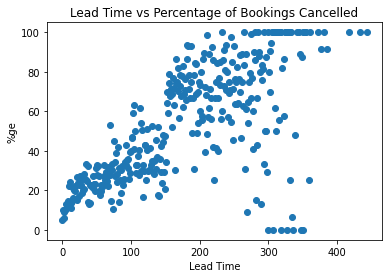

In [678]:
#Scatter plot of lead time and label
df_oc=df_o.copy()
df_oc['booking_status']=df_oc['booking_status'].apply(lambda x:1 if x=='Canceled' else 0)
plt.scatter(df_oc.groupby(by='lead_time').apply('mean').reset_index()['lead_time'],df_oc.groupby(by='lead_time').apply('mean').reset_index()['booking_status']*100)
plt.title('Lead Time vs Percentage of Bookings Cancelled');
plt.xlabel('Lead Time')
plt.ylabel('%ge')

From our testing we are able to conclude a few things, we notice that Gradient boosted didn't work as well as the Decision Tree for the hodel problem, and this makes sense, as Decision Trees perform better for simpler datasets with linear relationships. We also noted how the Gradient Boosted tree performed better on our more complicated dataset. We finally noted that gradient Boosted Trees were more impervious to noisy features, testament to their generalibility capabilities.

### KNN

Now let's move onto instance based models.

In [721]:
#Unlike other models we need to standardize the data, as KNN's work on the principle of distance, very different ranges can have effect on accuracy, to standardize we can't do all dataset, we do train, use that on valid then use that on test

X,Y=load_hotel()


from sklearn.preprocessing import StandardScaler

sklr=StandardScaler()
X_train_standardized=sklr.fit_transform(X_train)
X_valid_standardized=sklr.transform(X_valid)
X_test_standardized=sklr.transform(X_test)

In [711]:
#As before we'll explore KNN classifiers parameters, go over strengths, weakrnesses etc.
from sklearn.neighbors import KNeighborsClassifier

#We'll be expliring n_neighbors, weight, and p let's begin

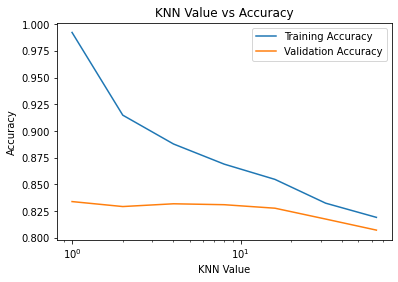

In [714]:
 #First let's test the effect of changing the value K, the number of neighbors, intuitively we know k=1 -> overfit, k=X.shape[0] -> underfit --> mode of the data

K_vals=[1]+[2**i for i in range(1,10) if X_train.shape[0]/5**i >=1]

train_acc=[]
test_acc=[]

#Running experiment 
for i in K_vals:
    knn=KNeighborsClassifier(n_neighbors=i,n_jobs=-1)

    knn.fit(X_train_standardized,y_train)
    train_acc.append(sklearn.metrics.accuracy_score(y_pred=knn.predict(X_train_standardized),y_true=y_train))
    test_acc.append(sklearn.metrics.accuracy_score(y_pred=knn.predict(X_valid_standardized),y_true=y_valid))

best_k_val=K_vals[np.argmax(test_acc)]

plt.plot(K_vals,train_acc,label='Training Accuracy')
plt.plot(K_vals,test_acc,label='Validation Accuracy')
plt.xscale('log')
plt.legend()
plt.ylabel('Accuracy');
plt.xlabel('KNN Value');
plt.title('KNN Value vs Accuracy');

In [686]:
#As expected K-> too low very good training performance, very bad generalizbility, underfit, k--> too large overfit, poor both

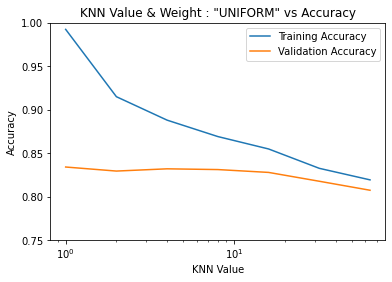

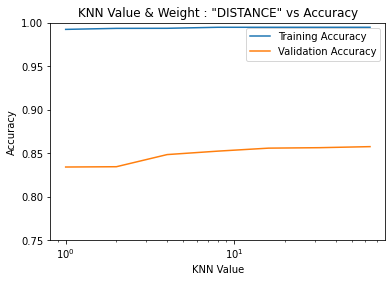

In [715]:
#Now lets look at weight, there are two real options uniform, (weighted equaly) and distance (weighted by distance) let's vary weights and KNN 
weights_list=['uniform','distance']
K_vals=[1]+[2**i for i in range(1,10) if X_train.shape[0]/5**i >=1]


#Running experiment 
for w in weights_list:
    train_acc=[]
    test_acc=[]

    for i in K_vals:
        knn=KNeighborsClassifier(n_neighbors=i,n_jobs=-1,weights=w)

        knn.fit(X_train_standardized,y_train)
        train_acc.append(sklearn.metrics.accuracy_score(y_pred=knn.predict(X_train_standardized),y_true=y_train))
        test_acc.append(sklearn.metrics.accuracy_score(y_pred=knn.predict(X_valid_standardized),y_true=y_valid))

    #best_k_val=K_vals[np.argmax(test_acc)]

    plt.figure()
    plt.plot(K_vals,train_acc,label='Training Accuracy')
    plt.plot(K_vals,test_acc,label='Validation Accuracy')
    plt.xscale('log')
    plt.legend()
    plt.ylabel('Accuracy');
    plt.xlabel('KNN Value');
    plt.ylim(0.75, 1)
    plt.title('KNN Value & Weight : "{}" vs Accuracy'.format(w.upper()));

In [697]:
#Note better performance, no overfitting

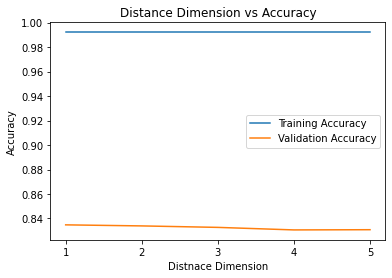

In [716]:
#Now let's do p value and see it's effects
P_list=[1,2,3,4,5]

train_acc=[]
test_acc=[]

#Running experiment 
for i in P_list:
    knn=KNeighborsClassifier(n_neighbors=best_k_val,p=i,n_jobs=-1)

    knn.fit(X_train_standardized,y_train)
    train_acc.append(sklearn.metrics.accuracy_score(y_pred=knn.predict(X_train_standardized),y_true=y_train))
    test_acc.append(sklearn.metrics.accuracy_score(y_pred=knn.predict(X_valid_standardized),y_true=y_valid))

best_p_val=P_list[np.argmax(test_acc)]

plt.plot(P_list,train_acc,label='Training Accuracy')
plt.plot(P_list,test_acc,label='Validation Accuracy')
#plt.xscale('log')
plt.legend()
plt.ylabel('Accuracy');
plt.xlabel('Distnace Dimension');
plt.title('Distance Dimension vs Accuracy');
plt.xticks(ticks=P_list);

In [ ]:
#All performed good, stick with standard

In [722]:
#Difference between standardized and non standardize, compare effects of not standardizing 

Params={
    'n_neighbors':[2,5,10],
    'weights':['uniform','distance'],
    'p':[1,2]
}

grid_knn_standardized=GridSearchCV(KNeighborsClassifier(),param_grid=Params,verbose=3,n_jobs=-1,cv=3,scoring='accuracy')
grid_knn=GridSearchCV(KNeighborsClassifier(),param_grid=Params,verbose=3,n_jobs=-1,cv=3,scoring='accuracy')

grid_knn_standardized.fit(X_train_standardized,y_train)
grid_knn.fit(X_train,y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [2, 5, 10], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=3)

In [724]:
#Not Standardized
print('The accuracy on the non standardized training data for the KNN classifier is {}'.format(sklearn.metrics.accuracy_score(y_pred=grid_knn.predict(X_train),y_true=y_train)))
print('The accuracy on the non standardized training data for the KNN classifier is {}'.format(sklearn.metrics.accuracy_score(y_pred=grid_knn.predict(X_test),y_true=y_test)))

#Standardized
print('The accuracy on the standardized training data for the KNN classifier is {}'.format(sklearn.metrics.accuracy_score(y_pred=grid_knn_standardized.predict(X_train_standardized),y_true=y_train)))
print('The accuracy on the standardized training data for the KNN classifier is {}'.format(sklearn.metrics.accuracy_score(y_pred=grid_knn_standardized.predict(X_valid_standardized),y_true=y_valid)))

The accuracy on the non standardized training data for the KNN classifier is 0.994486560992419
The accuracy on the non standardized training data for the KNN classifier is 0.8377670572019297
The accuracy on the standardized training data for the KNN classifier is 0.994486560992419
The accuracy on the standardized training data for the KNN classifier is 0.8568228807718815


In [725]:
#Quite a reasonable improvement

#### KNN results Hotel

In [737]:
#Finally let's see the best performance for the KNN on our hotel dataset

X,Y=load_hotel()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=42)

sklr=StandardScaler()
X_train_standardized=sklr.fit_transform(X_train)
X_test_standardized=sklr.transform(X_test)

Params={
    'n_neighbors':[2,5,10],
    'weights':['uniform','distance'],
    'p':[1,2]
}

grid_knn_standardized=GridSearchCV(KNeighborsClassifier(),param_grid=Params,verbose=3,n_jobs=-1,cv=3,scoring='accuracy')
grid_knn_standardized.fit(X_train_standardized,y_train)

#Standardized
print('The accuracy on the standardized training data for the KNN classifier is {}'.format(sklearn.metrics.accuracy_score(y_pred=grid_knn_standardized.predict(X_train_standardized),y_true=y_train)))
print('The accuracy on the standardized training data for the KNN classifier is {}'.format(sklearn.metrics.accuracy_score(y_pred=grid_knn_standardized.predict(X_test_standardized),y_true=y_test)))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
The accuracy on the standardized training data for the KNN classifier is 0.9939007580978635
The accuracy on the standardized training data for the KNN classifier is 0.8698828394210889


#### Exploring Dimensionality, unbalanced & Noisy data effect

In [761]:
#KNN is sensitive to too many columns of useless info and noisy data, same as before, let's use hotel data to see this in aciton
X,Y=load_hotel()

#Now let's split the data between test and train, we'll use the standard 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=42)

#We'll also split the data between train and validation, we'll again use the standard 80/20 split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2,random_state=42)

sklr=StandardScaler()
X_train_standardized=sklr.fit_transform(X_train)
X_valid_standardized=sklr.transform(X_valid)
X_test_standardized=sklr.transform(X_test)

Unbalanced Data

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits


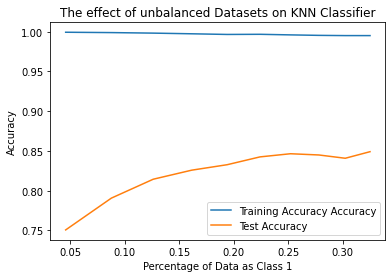

In [762]:
#Making Data Unbalanced
ind_1=np.argwhere(y_train==1)
ind_0=np.argwhere(y_train==0)
train_acc=[]
test_acc=[]
class_1_size=[]

#Now let's perform the experiment and create a graph at the end
for percentage_of_ones_factor in np.linspace(0.1,1,10):
    #Sampling
    selected_ind=np.random.choice(ind_1.ravel(),size=int(len(ind_1)*percentage_of_ones_factor))
    X_train_unbalanced=np.r_[X_train_standardized[ind_0.ravel(),:],X_train_standardized[selected_ind,:]]
    y_train_unbalanced=np.r_[y_train[ind_0.ravel()],y_train[selected_ind]]
    class_1_size.append(len(selected_ind)/(len(selected_ind)+len(ind_0)))

    #Grid Search
    Params={
    'n_neighbors':[2,5,10],
    'weights':['uniform','distance'],
    'p':[1,2]
    }

    grid_knn_ex=GridSearchCV(KNeighborsClassifier(),param_grid=Params,verbose=3,n_jobs=-1,cv=3,scoring='accuracy')
    grid_knn_ex.fit(X_train_unbalanced,y_train_unbalanced)

    
    #Testing with validation data not having been 'unbalanced'
    train_acc.append(sklearn.metrics.accuracy_score(y_pred=grid_knn_ex.predict(X_train_unbalanced),y_true=y_train_unbalanced))

    test_acc.append(sklearn.metrics.accuracy_score(y_pred=grid_knn_ex.predict(X_valid_standardized),y_true=y_valid))

#Plotting
plt.plot(class_1_size,train_acc,label='Training Accuracy Accuracy')
plt.plot(class_1_size,test_acc,label='Test Accuracy')
#plt.xscale('log')
plt.legend()
plt.ylabel('Accuracy');
plt.xlabel('Percentage of Data as Class 1');
plt.title('The effect of unbalanced Datasets on KNN Classifier');

In [763]:
#We see as exoected very big increase as dataset less unbalanced

Noisy Data

Fitting 3 folds for each of 12 candidates, totalling 36 fits


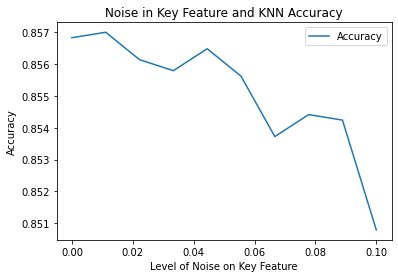

In [785]:
#We know that the most important factor is the lead time, same as before, let's train a dataset and add some noisy data to the lead time for validation and see the effect 

#Getting distributions for our two features with the highest predictive power, from our test set
lead_mean,lead_std=np.mean(X_valid_standardized[:,col_index['lead_time']]),np.std(X_valid_standardized[:,col_index['lead_time']])
special_req_mean,special_requests_std=np.mean(X_valid_standardized[:,col_index['no_of_special_requests']]),np.std(X_valid_standardized[:,col_index['no_of_special_requests']])

level_of_noise=[]
knn_accuracy=[]

#Grid Search
Params={
'n_neighbors':[2,5,10],
'weights':['uniform','distance'],
'p':[1,2]
}

grid_knn=GridSearchCV(KNeighborsClassifier(),param_grid=Params,verbose=3,n_jobs=-1,cv=3,scoring='accuracy')
grid_knn.fit(X_train_standardized,y_train)

for i in np.linspace(0,.1,10):
    #Creating Distributions to add
    lead_dist=np.random.normal(lead_mean*i,lead_std*i,X_valid_standardized.shape[0])
    special_req_dist=np.random.normal(special_req_mean*i,special_requests_std*i,X_valid_standardized.shape[0])

    #Now let's add this to our test X data
    X_valid_altered=X_valid_standardized.copy()

    X_valid_altered[:,col_index['lead_time']]=X_valid_altered[:,col_index['lead_time']]+lead_dist
    X_valid_altered[:,col_index['no_of_special_requests']]=X_valid_altered[:,col_index['no_of_special_requests']]+special_req_dist

    #Appending Level of noise
    level_of_noise.append(i)

    #Getting Accuracy
    knn_accuracy.append(sklearn.metrics.accuracy_score(y_pred=grid_knn.predict(X_valid_altered),y_true=y_valid))

#Plotting
plt.plot(level_of_noise,knn_accuracy,label='Accuracy')
#plt.xscale('log')
plt.legend()
plt.ylabel('Accuracy');
plt.xlabel('Level of Noise on Key Feature');
plt.title('Noise in Key Feature and KNN Accuracy');

In [786]:
#Best hold

Noisy Features

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits


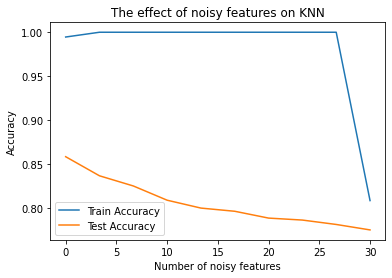

In [790]:
#We'll add features to our training data, that are just noise, and observe the effect on the classifier. 
knn_noisy_train=[]
knn_noisy_test=[]
useless_features=np.linspace(0,30,10)

X,Y=load_hotel()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=42)

sklr=StandardScaler()
X_train_standardized=sklr.fit_transform(X_train)

for uf in useless_features:
    X_noisy=X_train_standardized.copy()
    X_noisy=np.c_[X_noisy,np.random.normal(size=(X_noisy.shape[0],int(uf)))]

    #Same as before splitting the data into train,test & validation data
    X_train_noisy, X_test_noisy, y_train_noisy, y_test_noisy = train_test_split(X_noisy, y_train, test_size=0.2,random_state=42)

    #Getting the optimized parameters
    Params={
    'n_neighbors':[5,10,15],
    'weights':['uniform','distance'],
    'p':[1,2]
    }

    grid_knn=GridSearchCV(KNeighborsClassifier(),param_grid=Params,verbose=3,n_jobs=-1,cv=3,scoring='accuracy')
    grid_knn.fit(X_train_noisy,y_train_noisy)

    #Optimized
    knn_noisy_train.append(sklearn.metrics.accuracy_score(y_pred=grid_knn.predict(X_train_noisy),y_true=y_train_noisy))

    knn_noisy_test.append(sklearn.metrics.accuracy_score(y_pred=grid_knn.predict(X_test_noisy),y_true=y_test_noisy))

#Plotting
plt.plot(useless_features,knn_noisy_train,label='Train Accuracy')
plt.plot(useless_features,knn_noisy_test,label='Test Accuracy')
#plt.xscale('log')
plt.legend()
plt.ylabel('Accuracy');
plt.xlabel('Number of noisy features');
plt.title('The effect of noisy features on KNN');

#### Satander KNN

In [741]:
#Now we can move on to the Satander Customer Data
X,Y=load_csr_data()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=42)

sklr=StandardScaler()
X_train_standardized=sklr.fit_transform(X_train)
X_test_standardized=sklr.transform(X_test)

Params={
    'n_neighbors':[2,5,10],
    'weights':['uniform','distance'],
    'p':[1,2]
}

grid_knn_standardized=GridSearchCV(KNeighborsClassifier(),param_grid=Params,verbose=3,n_jobs=-1,cv=3,scoring='recall')
grid_knn_standardized.fit(X_train_standardized,y_train)

#Standardized
print('The accuracy on the standardized training data for the KNN classifier is {}'.format(sklearn.metrics.accuracy_score(y_pred=grid_knn_standardized.predict(X_train_standardized),y_true=y_train)))
print('The accuracy on the standardized training data for the KNN classifier is {}'.format(sklearn.metrics.accuracy_score(y_pred=grid_knn_standardized.predict(X_test_standardized),y_true=y_test)))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
The accuracy on the standardized training data for the KNN classifier is 1.0
The accuracy on the standardized training data for the KNN classifier is 0.9313996316758748


In [742]:
#AUC and F1 score 

#AUC
print('The AUC score on the standardized training data for the KNN classifier is {}'.format(sklearn.metrics.roc_auc_score(y_score=grid_knn_standardized.predict(X_train_standardized),y_true=y_train)))
print('The AUC score on the standardized training data for the KNN classifier is {}'.format(sklearn.metrics.roc_auc_score(y_score=grid_knn_standardized.predict(X_test_standardized),y_true=y_test)))

#F1
print('The F1 standardized training data for the KNN classifier is {}'.format(sklearn.metrics.f1_score(y_pred=grid_knn_standardized.predict(X_train_standardized),y_true=y_train)))
print('The F1 standardized training data for the KNN classifier is {}'.format(sklearn.metrics.f1_score(y_pred=grid_knn_standardized.predict(X_test_standardized),y_true=y_test)))

The AUC score on the standardized training data for the KNN classifier is 1.0
The AUC score on the standardized training data for the KNN classifier is 0.5269073140099312
The F1 standardized training data for the KNN classifier is 1.0
The F1 standardized training data for the KNN classifier is 0.09225413402959094


### SVM 